<a href="https://colab.research.google.com/github/vladimirzotk1n/Text-Sentiment-Analysis/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import string
import emoji
import re
import spacy
import warnings
import torch


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import torch.nn as nn
import gensim.downloader as api
import torch.optim as optim


from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from contractions import fix
from bs4 import BeautifulSoup
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch import tensor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV


nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed-dataset/preprocessed_dataframe.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [ ]:
data = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
data.drop('2401', axis = 1, inplace = True)
data.head()

,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


# EDA + Preprocessing

In [ ]:
data.rename(columns = {'Borderlands' : 'Source',
                       'Positive' : 'Emotion',
                       'im getting on borderlands and i will murder you all ,' : 'Text'},
            inplace = True)

In [ ]:
data.head()['Text'].values

array(['I am coming to the borders and I will kill you all,',
       'im getting on borderlands and i will kill you all,',
       'im coming on borderlands and i will murder you all,',
       'im getting on borderlands 2 and i will murder you me all,',
       'im getting into borderlands and i can murder you all,'],
      dtype=object)

In [ ]:
for col in data.columns:
    print(col, '   :   ', data[col].unique())
    print()

Source    :    ['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']

Emotion    :    ['Positive' 'Neutral' 'Negative' 'Irrelevant']

Text    :    ['I am coming to the borders and I will kill you all,'
 'im getting on borderlands and i will kill you all,'
 'im coming on borderlands and i will murder you all,' ...
 'Just realized the windows partition of my Mac is now 6 years behind on Nvidia drivers and I have no idea how he didn’t notice'
 'Just realized between the windows partition of my Mac is like being 6 years behind on Nvidia drivers and cars I hav

In [ ]:
data.isnull().sum()

Source       0
Emotion      0
Text       686
dtype: int64

In [ ]:
data.duplicated().sum()

3621

In [ ]:
data.dropna(inplace = True)

In [ ]:
data.drop_duplicates(inplace = True)

In [ ]:
emotion_counts = data['Emotion'].value_counts().reset_index()

fig = px.pie(emotion_counts, values = 'count', names = 'Emotion', title = 'Target distribution')
fig.show()

In [ ]:
emotion_counts = data['Source'].value_counts().reset_index()

fig = px.pie(emotion_counts, values = 'count', names = 'Source', title = 'Source distribution')
fig.show()

In [ ]:
emotions = ['Positive', 'Negative', 'Neutral', 'Irrelevant']

emotions = ['Positive', 'Negative', 'Neutral', 'Irrelevant']

fig = go.Figure()

for emotion in emotions:
    sources = data.loc[data['Emotion'] == emotion, 'Source'].value_counts()

    fig.add_trace(go.Bar(
        x=sources.index,
        y=sources.values,
        name=emotion
    ))

fig.update_layout(
    title="Emotion distribution in Sources",
    xaxis_title="Text Source",
    yaxis_title="Frequency",
    paper_bgcolor="lightgray",
    plot_bgcolor="whitesmoke",
    font=dict(
        color="black",
        size=16
    ),
    legend_title="Emotion"
)

fig.show()

In [ ]:
emotions = ['Positive', 'Negative', 'Neutral', 'Irrelevant']

fig = go.Figure()

for emotion in emotions:
    lens = data.loc[data['Emotion'] == emotion, 'Text'].str.len()

    fig.add_trace(go.Histogram(
        x=lens,
        name=emotion,
        nbinsx=300
    ))

fig.update_layout(
    title="Text Lengths by Emotion",
    xaxis_title="Text Length",
    yaxis_title="Density",
    paper_bgcolor="lightgray",
    plot_bgcolor="whitesmoke",
    font=dict(
    color="black",
    size=16
    ),
    barmode='overlay',
    legend_title="Emotion"
)

fig.show()

In [ ]:
class Preprocessor:
    def __init__(self, min_occur=None):
        self.min_occur = min_occur

    @staticmethod
    def expand_contractions(text):
        if not isinstance(text, str):
            text = str(text)
        text = text.lower()
        return fix(text)

    @staticmethod
    def remove_html(text):
        return BeautifulSoup(text, 'html.parser').get_text().strip()

    @staticmethod
    def remove_links(text):
        url_pattern = r'http[s]?://\S+'
        text = re.sub(url_pattern, '', text)

        com_pattern = r'\b\w+\.com\b'
        text = re.sub(com_pattern, '', text)
        return text.strip()

    @staticmethod
    def replace_emoji(text):
        emoji_pattern = emoji.EMOJI_DATA.keys()
        tokens = re.findall(r'\w+|[' + re.escape(string.punctuation) + ']|' + '|'.join(map(re.escape, emoji_pattern)), text)

        result = []
        for token in tokens:
            if token in emoji.EMOJI_DATA:
                token = emoji.demojize(token, language='en')
                token = re.sub(r'[' + re.escape(string.punctuation) + ']', ' ', token)
            result.append(token)

        return ' '.join(result).strip()

    @staticmethod
    def filter(text):
        doc = nlp(text)
        text = ' '.join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha and not token.is_punct])
        return text.strip()

    def clip_rare_words(self, text, words_counter):
        return ' '.join([word for word in text.split() if words_counter[word] >= self.min_occur]).strip()

    def fit(self, data):
        data['Text'] = data['Text'].astype(str).apply(self.expand_contractions)
        data['Text'] = data['Text'].apply(self.remove_html)
        data['Text'] = data['Text'].apply(self.remove_links)
        data['Text'] = data['Text'].apply(self.replace_emoji)
        data['Text'] = data['Text'].apply(self.filter)

        if self.min_occur:
            words_counter = Counter()
            for sentence in data['Text']:
                words_counter.update(sentence.split())
            data['Text'] = data['Text'].apply(lambda text: self.clip_rare_words(text, words_counter))

        data['Text'] = data['Text'].apply(lambda text: re.sub(r'\s+', ' ', text).strip())

        return data

In [ ]:
s = '<p>Hello, this is test string! </p> 🌍 .... ???Check our site: <a href="https://www.example.com">example.com</a> for more information. LINK US here: Twitter @example, Instagram @example>>>  📸, и Facebook: <a href="https://www.facebook.com/example">facebook.com/example</a>. Also here is a list: 1️⃣ - FIrst element, 2️⃣ - SeCOND ELEMENT, 3️⃣ - THIRD ELEMENT! 🎉'

In [ ]:
print(Preprocessor().fit(pd.DataFrame({'Text' : pd.Series(s)})).values)

[['hello globe show Europe Africa check site information link social medium twitter example instagram example camera flash и facebook example list element second element element party popper']]


In [ ]:
%%time

preprocessor = Preprocessor(20)
data = preprocessor.fit(data)

CPU times: user 11min 50s, sys: 135 ms, total: 11min 51s
Wall time: 11min 51s


In [ ]:
data = data.fillna('')

In [ ]:
freq_map = {
    'Positive' : Counter(),
    'Negative' : Counter(),
    'Neutral' : Counter(),
    'Irrelevant' : Counter()
}

for _, row in data.iterrows():
    freq_map[row['Emotion']].update(row['Text'].split())

n_most_common = 40

fig = make_subplots(rows = 2, cols = 2)

for i, emotion in enumerate(freq_map.keys()):
    row, col = divmod(i, 2)
    df = pd.DataFrame(freq_map[emotion].most_common(n_most_common), columns = ['Word', 'Count']).sort_values(by = 'Count')
    fig.add_trace(
        go.Bar(y = df['Count'], x = df['Word'], name = emotion),
        row = row + 1,
        col = col + 1
    )

    fig.update_layout(
        title = 'Most common words',
        paper_bgcolor="lightgray",
        plot_bgcolor="whitesmoke",
        font=dict(
        color="black",
        size=16
        ),
        legend_title = 'Emotion',
        height = 1000,
        width = 2000,
        showlegend = True
    )
fig.show()

In [ ]:
unique_words = set()
for text in data['Text']:
    for word in text.split():
        unique_words.add(word)
print(f'Total : {len(unique_words)} unique words')

Total : 21917 unique words


# Encoding

In [ ]:
enc = LabelEncoder()
data['Source'] = enc.fit_transform(data['Source'])

In [ ]:
data['Emotion'] = data['Emotion'].map({'Positive' : 3,
                                       'Neutral' : 2,
                                       'Negative' : 1,
                                       'Irrelevant' : 0
                                      })

In [ ]:
data

,Source,Emotion,Text
0,4,3,come border kill
1,4,3,get borderland kill
2,4,3,come borderland murder
3,4,3,get borderland murder
4,4,3,get borderland murder
...,...,...,...
74676,21,3,realize window partition mac like year nvidia ...
74677,21,3,realize mac window partition year nvidia drive...
74678,21,3,realize window partition mac year nvidia drive...
74679,21,3,realize window partition mac like year nvidia ...


# Test Models

# ML + TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))
X_train, X_test, y_train, y_test = train_test_split(data.drop('Emotion', axis = 1), data['Emotion'], test_size = 0.2, random_state = 42)

X_train_tfidf = pd.DataFrame(vectorizer.fit_transform(X_train['Text']).toarray(), columns = vectorizer.get_feature_names_out())
X_test_tfidf = pd.DataFrame(vectorizer.transform(X_test['Text']).toarray(), columns = vectorizer.get_feature_names_out())

In [ ]:
def train_model(model, params):
    cv = KFold(shuffle = True)

    rs = RandomizedSearchCV(
        estimator = model,
        param_distributions=params,
        n_iter = 20,
        scoring = 'accuracy',
        cv = cv
    )
    rs.fit(X_train_tfidf, y_train)
    print(rs.best_params_)
    return rs.best_estimator_

logreg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}
logreg = train_model(LogisticRegression(), logreg_params).fit(X_train_tfidf, y_train)

In [ ]:
logreg = LogisticRegression(C=1, solver="liblinear").fit(X_train_tfidf, y_train)
pred = logreg.predict(X_test_tfidf)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

  Irrelevant       0.98      0.79      0.88      2411
    Negative       0.78      0.97      0.86      4248
     Neutral       0.93      0.87      0.90      3404
    Positive       0.92      0.84      0.88      3806

    accuracy                           0.88     13869
   macro avg       0.90      0.87      0.88     13869
weighted avg       0.89      0.88      0.88     13869



<Axes: >

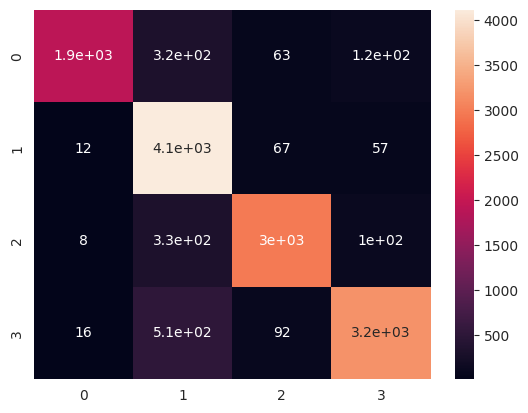

In [ ]:
sns.heatmap(confusion_matrix(y_test, pred), annot = True)

In [ ]:
nb = MultinomialNB().fit(X_train_tfidf, y_train)
pred = nb.predict(X_test_tfidf)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

  Irrelevant       0.99      0.81      0.89      2411
    Negative       0.80      0.97      0.88      4248
     Neutral       0.95      0.89      0.92      3404
    Positive       0.92      0.86      0.89      3806

    accuracy                           0.89     13869
   macro avg       0.91      0.88      0.89     13869
weighted avg       0.90      0.89      0.89     13869



<Axes: >

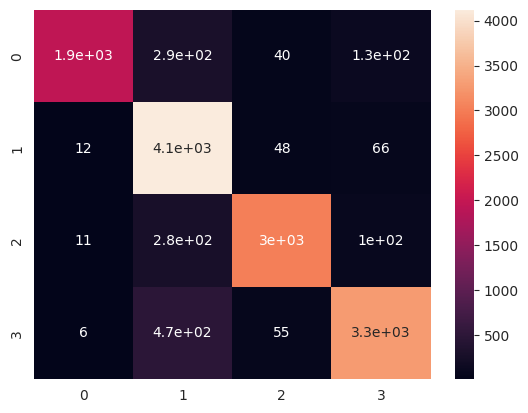

In [ ]:
sns.heatmap(confusion_matrix(y_test, pred), annot = True)

# DL PART

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
glove = api.load("glove-twitter-200")

In [ ]:
word_count = Counter()
for text in data['Text']:
    word_count.update(text.split())


vocabulary, _ = zip(*word_count.most_common(5000))

In [ ]:
vocabulary = ['<unk>', '<pad>'] + list(vocabulary)

In [ ]:
vocabulary[:5]

['<unk>', '<pad>', 'game', 'play', 'good']

In [ ]:
word_to_index = dict({word : i for i, word in enumerate(vocabulary)})

In [ ]:
embedding_dim = 200

def create_matrix(vocabulary):
    matrix = np.zeros((len(vocabulary), embedding_dim))
    for i, word in enumerate(vocabulary):
        if word in glove:
            matrix[i] = glove[word]
        else:
            matrix[i] = np.random.normal(scale = 1, size = (embedding_dim,))
    return tensor(matrix, dtype = torch.float).to(device)

embedding_matrix = create_matrix(vocabulary)

In [ ]:
embedding_matrix.shape

torch.Size([5002, 200])

In [ ]:
class PandasDataset(Dataset):
    def __init__(self, data, unk_idx):
        self.data = data
        self.unk_idx = unk_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['Text']

        text_features = [word_to_index.get(word, self.unk_idx) for word in text.split()]
        cat_features = [self.data.iloc[idx]['Source']]
        label = [self.data.iloc[idx]['Emotion']]

        item = {
            'text' : text_features,
            'cat' : cat_features,
            'label' : label
        }

        return item

In [ ]:
pad_idx, default_max_len = 1, 300

def collate_fn(batch):
    max_len = min(max(list(len(seq['text']) for seq in batch)), default_max_len)

    sequences = []
    for seq in batch:
        seq['text'] = seq['text'][:max_len]
        seq['text'] += (max_len - len(seq['text'])) * [pad_idx]
        sequences.append(seq['text'])

    padded_batch = {
        'text' : torch.LongTensor(sequences).to(device),
        'cat' : torch.LongTensor([seq['cat'] for seq in batch]).to(device),
        'label' : torch.LongTensor([seq['label'] for seq in batch]).to(device)
    }
    return padded_batch

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Emotion', axis = 1), data['Emotion'], test_size = 0.2, random_state = 42, shuffle = True)
train_dataset = PandasDataset(pd.concat([X_train, y_train], axis = 1), 0)
test_dataset = PandasDataset(pd.concat([X_test, y_test], axis = 1), 0)

train_dataloader = DataLoader(train_dataset, collate_fn = collate_fn, batch_size = 2000, shuffle = True)
test_dataloader = DataLoader(test_dataset, collate_fn = collate_fn, batch_size = 2000, shuffle = True)

In [ ]:
def train(model, criterion, optimizer, epochs = 200):
    test_accuracy_scores = []
    train_accuracy_scores = []

    for epoch in range(epochs):
        model.train()
        total_correct = 0
        total_samples = 0

        for train_batch in train_dataloader:
            pred = model(train_batch['text'], train_batch['cat'])

            pred_classes = torch.argmax(pred, dim = 1)
            correct = (pred_classes == train_batch['label'].squeeze(1)).sum().item()
            total_correct += correct
            total_samples += train_batch['label'].size(0)

            loss = criterion(pred, train_batch['label'].squeeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_accuracy = total_correct / total_samples
        train_accuracy_scores.append(train_accuracy)

        model.eval()
        total_correct = 0
        total_samples = 0

        with torch.inference_mode():
            for test_batch in test_dataloader:
                pred = model(test_batch['text'], test_batch['cat'])

                pred_classes = torch.argmax(pred, dim = 1)

                correct = (pred_classes == test_batch['label'].squeeze(1)).sum().item()
                total_correct += correct
                total_samples += test_batch['label'].size(0)

        accuracy = total_correct / total_samples
        print(accuracy)
        test_accuracy_scores.append(accuracy)

    return train_accuracy_scores, test_accuracy_scores

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, output_size, num_topics, topic_embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings=embedding_matrix, freeze=False)

        self.topic_embedding = nn.Embedding(num_topics, topic_embedding_dim)

        self.lstm1 = nn.LSTM(embedding_dim, 128, bidirectional=True, batch_first=True)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)

        self.lstm2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 + topic_embedding_dim, 64)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x, topic):
        # Эмбеддинг для текста
        x = self.embedding(x)

        # Первый LSTM слой
        x, _ = self.lstm1(x)
        x = self.batch_norm1(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.dropout1(x)

        # Второй LSTM слой
        x, _ = self.lstm2(x)
        x = self.batch_norm2(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.dropout2(x)

        # Берём последнее скрытое состояние
        x = x[:, -1, :]

        # Эмбеддинг для темы
        topic_embedded = self.topic_embedding(topic).squeeze(1)
        # Объединяем x и topic_embedded
        x = torch.cat((x, topic_embedded), dim=1)

        # Полносвязные слои
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout3(x)

        x = self.fc2(x)

        return x

In [ ]:
model = BiLSTMModel(200, 4, 32, 50).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 3e-4)

In [ ]:
train_accuracy_scores, test_accuracy_scores = train(model, criterion, optimizer)

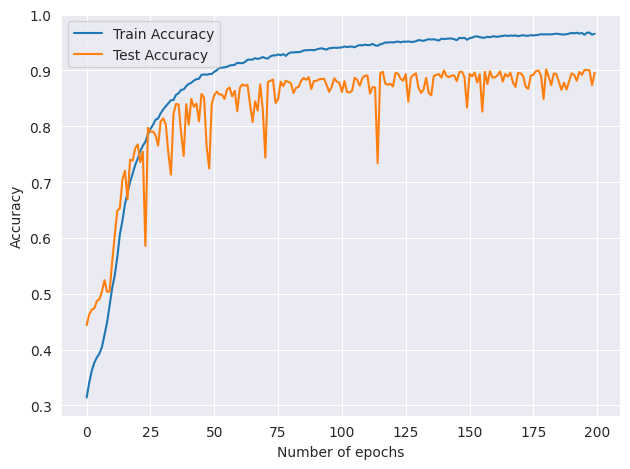

In [ ]:
plt.plot(np.arange(200), train_accuracy_scores, label='Train Accuracy')
plt.plot(np.arange(200), test_accuracy_scores, label='Test Accuracy')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()